# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение файла

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from tqdm import tqdm

In [3]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.datasets import load_iris
from sklearn import tree

In [4]:
df = pd.read_csv('/datasets/users_behavior.csv')

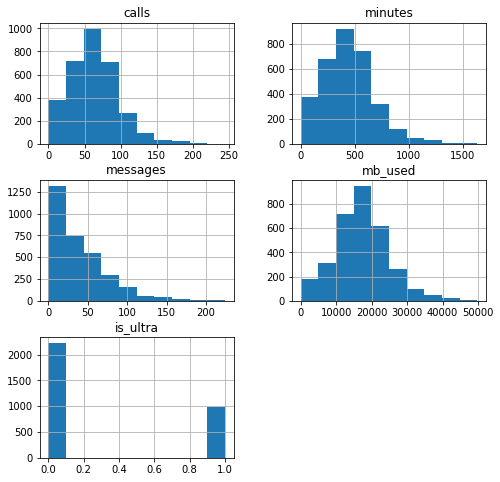

In [8]:
df.hist(figsize=(8,8));

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [7]:
df.corr(method='spearman')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.978684,0.155032,0.253886,0.160549
minutes,0.978684,1.000000,0.153784,0.248818,0.159991
messages,0.155032,0.153784,1.000000,0.141999,0.106537
mb_used,0.253886,0.248818,0.141999,1.000000,0.154989
is_ultra,0.160549,0.159991,0.106537,0.154989,1.000000


Коэффициент корреляции можно считать высоким, если он больше 0.7. Тут видна сильная связь между кол-вом звонков и минутами. 

## Разбейте данные на выборки

Разобьем выборку в следующих пропорциях: 60-20-20. Целевым признаком будет 'is_ultra' - выбранный тариф.

In [9]:
features = df.drop(['is_ultra'],axis= 1)
target = df['is_ultra']
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target,
                                                                            test_size=.4, random_state=12345)
#обучающая выборка
print(features_train.shape)
print(target_train.shape)

(1928, 4)
(1928,)


In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, stratify=target_test,
                                                                            test_size=.5, random_state=12345)
#тестовая выборка, на которой мы будем проверять модель
print(features_test.shape)
print(target_test.shape)
#валидационная выборка
print(features_valid.shape)
print(target_valid.shape)

(643, 4)
(643,)
(643, 4)
(643,)


## Исследование модели

### Решающее древо

Начнем с модели решающего дерева. У нее низкое качество, но зато высокая скорость.

In [10]:
best_model = None
best_result = 0
train_list = []
valid_list = []
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) #модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучение модели
    predictions = model.predict(features_valid) #предсказания модели
    result = accuracy_score(target_valid, predictions) #качество модели
    valid_list.append(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

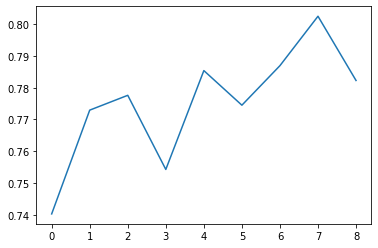

In [11]:
plt.plot(valid_list);

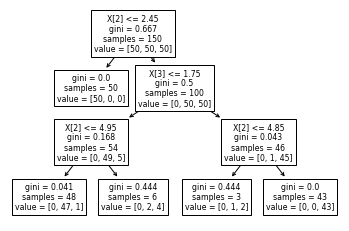

In [12]:
clf = tree.DecisionTreeClassifier(random_state=12345, max_depth=3)
iris = load_iris()
clf = clf.fit(iris.data, iris.target)
tree.plot_tree(clf);

In [13]:
print("Accuracy лучшей модели:", best_result)
print("Выбранная глубина: ", best_depth)

Accuracy лучшей модели: 0.80248833592535
Выбранная глубина:  8


Значение accuracy > 0.75 - уже неплохо, посмотрим, что будет на следующих. 

### Логистическая регрессия

Посмотрим на модель логистической регрессии - ее качество должно быть немного выше древа.

In [11]:
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_log.fit(features_train, target_train)
predictions_log = model_log.predict(features_valid)
result =  accuracy_score(target_valid, predictions_log)

In [12]:
print("Accuracy",result)

Accuracy 0.7387247278382582


Accuracy меньше 0.75 - данная модель нам не подходит. 

### Случайный лес

У случайного леса высокое качество, но низкая скорость. Скорее всего, будет выбрана эта модель - в данном случае скорость нам не критична, а точность будет (должна быть...) выше.

In [16]:
for n_estimators in tqdm(range(5)):
    best_model_forest = None
    best_result_forest = 0
    best_depth_forest = 0
    for est in  range(10, 101, 10):
        for depth in range(1, 21, 1):
            model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
            model_forest.fit(features_train,target_train)
            predictions_valid = model_forest.predict(features_valid)
            result =  accuracy_score(target_valid, predictions_valid)
            if result > best_result_forest:
                best_model_forest = model_forest
                best_est = est
                best_result_forest = result
                best_depth_forest = depth

100%|██████████| 5/5 [02:39<00:00, 31.98s/it]


In [20]:
print("Accuracy", best_result_forest)
print('Глубина',best_depth_forest)
print('Кол-во деревьев', best_est)

Accuracy 0.8211508553654744
Глубина 9
Кол-во деревьев 40


Accuracy = 0.81, что больше 0.75 и больше, чем в двух предыдущих моделях. Значит для длальнейшей работы выбираем случайный лес.

## Проверьте модель на тестовой выборке

Проверяем модель случайного леса на тестовой выборке

In [21]:
model_forest = RandomForestClassifier(random_state = 12345, max_depth = 9, n_estimators = 40)
model_forest.fit(features_train, target_train)
predict_forest = model_forest.predict(features_test)
accuracy_forest = accuracy_score(predict_forest, target_test)
print("Accuracy итоговой модели:",accuracy_forest)

Accuracy итоговой модели: 0.8087091757387247


In [13]:
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_log.fit(features_train, target_train)
predictions_log = model_log.predict(features_test)
result =  accuracy_score(predictions_log, target_test)
print("Accuracy итоговой модели:",result)

Accuracy итоговой модели: 0.7465007776049767


In [17]:
print(predictions_log)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Качество получивгейся модели ~ 0.80, что больше 0.75 и нам подходит. Оставляем эту модель.

## Проверка модели на адекватность

<b>Комментарии студента:</b> Я понимаю, что для проверки модели на адекватность можно сравнить ее со случайной моделью, в том числе с помощью Dummy. Но не совсем понимаю, каким образом эту случайную выборку создать... Была бы признательна, если бы подсказали, каким образом это можно сделать. Или подсказали источник, где про это можно почитать.

Я нашла статью про Dummy, где был дан простой пример, но я все равно не совсем понимаю, каким образом эт выборки привести к тому, что мне надо

In [23]:
m = DummyClassifier(strategy='most_frequent', random_state=1) 
m.fit(features_train, target_train)
m.predict(features_test)
m.score(features_test, target_test)

0.6936236391912908

Можно сравнить метрики train и test. В идеале, они не должно сильно различаться, особенно, если модель не очень сложная. Accuracy для случайного леса у test-выборки = 0.802, а при исследовании моделей у train значение accuracy = 0.804. Значения очень близки друг к другу, поэтому можно сказать, что получившаяся модель адекватна. 

## Вывод

Для анализа поставленной задачи были представлены данные о поведении клиентов, которые уже перешли на тарифы "Смарт" и "Ультра". Перед этим данные немного доработались, например, некоторые столбцы приведены к временному типу, некоторые к целочисленному, также были посчитаны новые столбцы (количество сделанных звонков разговора/израсходованных минут/отправленных сообщений/потраченных мегабайт) для каждого пользователя по месяцам.

Для создания модели данные были разбиты на 3 выборки в соотношении 60:20:20 (обучающая:тестовая:валидационная). Перед выбором конечной модели были рассмотрены: решающее древо (качество = 0.80), логистическая регрессия (качество = 0.73) и случайный лес (качество = 0.82). Метрика качества случайного леса была выше, поэтому для дальнейшей работы была выбрана эта модель.

После проверки модели на тестовой выборки accuracy = 0.80, что больше 0.75, поэтому полученные результаты нас устраивают. Также модель проверена на адекватность с помощью dummy-решения.